# Analysis of heart rate (HR) during sleep and how it relates to daily ratings of subjective sleep quality and energy

# Set working directory

In [1]:
cd /Users/charlesmartens/Documents/projects/fitbit_data

/Users/charlesmartens/Documents/projects/fitbit_data


# Import modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import csv
import copy
from matplotlib.dates import DateFormatter
import warnings
import missingno as msno
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
sns.set_style('white')
%matplotlib inline

In [3]:
warnings.filterwarnings('ignore')

# Open data file and put date/time variables into datetime format

In [40]:
df_hr_continuous_min = pd.read_csv('df_hr_for_analyses.csv')
#df_hr_continuous_min.columns

In [8]:
df_hr_continuous_min['date_time'] = pd.to_datetime(
    df_hr_continuous_min['date_time'])

df_hr_continuous_min['date'] = pd.to_datetime(
    df_hr_continuous_min['date'])

df_hr_continuous_min['date_sleep'] = pd.to_datetime(
    df_hr_continuous_min['date_sleep'])

# set index to date_time:
df_hr_continuous_min.index = df_hr_continuous_min['date_time']

df_hr_continuous_min = df_hr_continuous_min[['date', 'date_sleep', 'sleep_status', 
                                             'hr', 'sleep_subjective', 'energy']]

# Snapshot of dataframe

In [9]:
df_hr_continuous_min[['hr', 'sleep_status', 'sleep_subjective', 'energy']][
    (df_hr_continuous_min['sleep_status'].notnull())].head()

,hr,sleep_status,sleep_subjective,energy
date_time,,,,
2016-10-01 01:29:00,54.0,2.0,3.0,NaN
2016-10-01 01:30:00,54.0,1.0,3.0,NaN
2016-10-01 01:31:00,52.0,2.0,3.0,NaN
2016-10-01 01:32:00,52.0,1.0,3.0,NaN
2016-10-01 01:33:00,53.0,1.0,3.0,NaN


* 'date_time' shows the year-month-day hour:minute:second
* 'hr' shows my HR each minute
* 'sleep_status' is the fitbit flag that shows if I was sleeping or awake during each minute
* 'sleep_subjective' is my rating of how well I think I slept
* 'energy' is my rating of how energetic I felt at the time of the rating

In [10]:
def plot_hr_and_hr_rolling_for_night(df_hr_continuous_min, date, 
                                     color_1, color_2, 
                                     resample_minutes, hr_metric_to_plot_1, 
                                     hr_metric_to_plot_2, alpha_level):
    # get data from one night
    df_night = df_hr_continuous_min[(df_hr_continuous_min['date_sleep']==date)]
    # select only data when alseep
    df_night_asleep = df_night[df_night['sleep_status']==1]
    # code to help plot x-axis
    df_night_asleep.loc[:, 'date_temporary_1'] = pd.to_datetime('2017-1-1')
    df_night_asleep.loc[:, 'date_temporary_2'] = pd.to_datetime('2017-1-2')   
    df_night_asleep.loc[:, 'date_time'] = df_night_asleep.index  
    df_night_asleep.loc[:, 'date_time_temporary'] = np.nan
    df_night_asleep.loc[df_night_asleep['date_time'].dt.hour>20, 
                        'date_time_temporary'] = pd.to_datetime(
        df_night_asleep.loc[:, 'date_temporary_1'].astype(str) + ' ' + 
        df_night_asleep['date_time'].dt.hour.astype(str) + ':' + 
        df_night_asleep['date_time'].dt.minute.astype(str))
    df_night_asleep.loc[df_night_asleep['date_time'].dt.hour<20, 
                        'date_time_temporary'] = pd.to_datetime(
        df_night_asleep.loc[:, 'date_temporary_2'].astype(str) + ' ' + 
        df_night_asleep['date_time'].dt.hour.astype(str) + ':' + 
        df_night_asleep['date_time'].dt.minute.astype(str))
    df_night_asleep = df_night_asleep.set_index('date_time_temporary')
    df_night_asleep = df_night_asleep[df_night_asleep.index < 
                                      '2017-01-02 11:00:00']
    # resample method to add back minutes that i was awake -- 
    # so now the timeline is real time
    # fills these awake minutes with nans, 
    # so will see breaks in hr for mins when awake. 
    df_night_asleep = df_night_asleep.resample(resample_minutes+'min').mean()      
    # plot
    ax = plt.figure(figsize=(13, 6))
    plt.plot(df_night_asleep.index, df_night_asleep[hr_metric_to_plot_1], 
             alpha=alpha_level, color=color_1, linewidth=1)
    plt.plot(df_night_asleep.index, df_night_asleep[hr_metric_to_plot_2], 
             alpha=.3, color=color_2, linewidth=4)  
    plt.ylabel('Heart Rate', fontsize=30)
    plt.xlabel('Time', fontsize=30)
    plt.ylim(40,80)
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    plt.title('\nA Night of Sleep', fontsize=30)
    ax.axes[0].xaxis.set_major_formatter(DateFormatter('%H:%M'))  
    ax.autofmt_xdate()
    sns.despine();

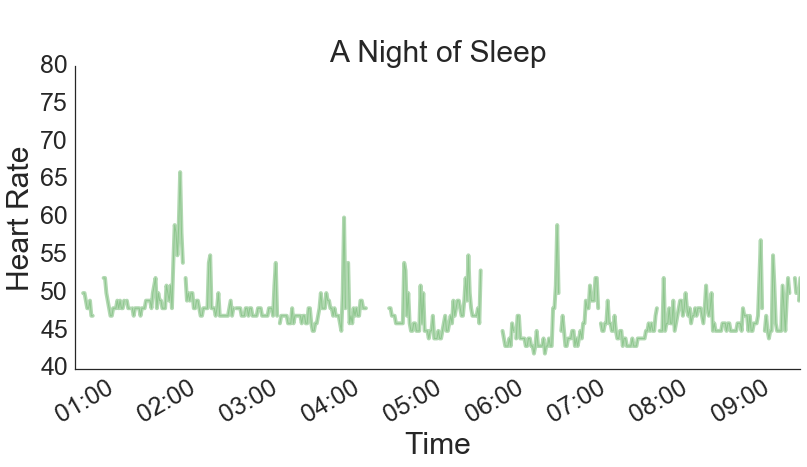

In [11]:
plot_hr_and_hr_rolling_for_night(df_hr_continuous_min, '2017-5-27', 
                                 'green', 'green', '1', 'hr', 'hr', .2);

# Compute smoothed (rolling average) HR

In [12]:
df_hr_continuous_min['hr_rolling'] = df_hr_continuous_min['hr'].rolling(
    window=30, center=True, min_periods=20).mean()

# Plot raw HR against smoothed HR

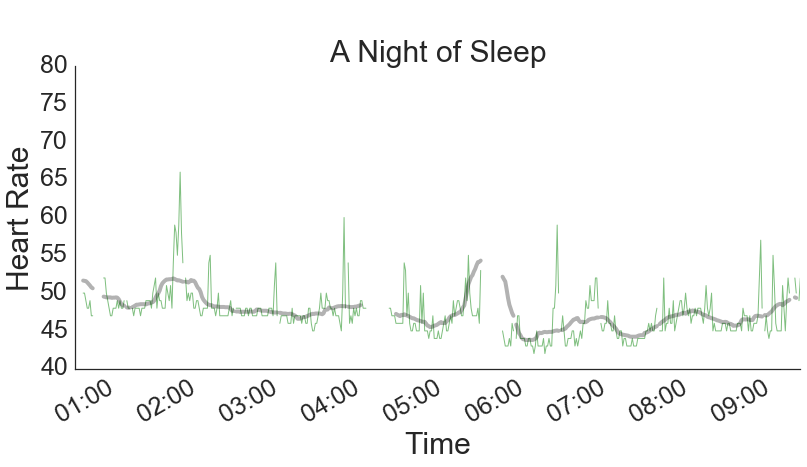

In [13]:
plot_hr_and_hr_rolling_for_night(df_hr_continuous_min, '2017-5-27', 'green', 
                                 'black', '1', 'hr', 'hr_rolling', .5);

# Remove HR outliers (10 bpm above/below smoothed HR) and compute smoothed HR again

In [14]:
def remove_hr_outliers(df):
    df['hr_rolling'] = df['hr_rolling'].interpolate()
    # label as outlier if hr is  +/- 10 bpm than the smoothed hr_rolling
    df['outlier'] = 0
    df.loc[(df['hr'] > (df['hr_rolling'] + 10)) |
    (df['hr'] < (df['hr_rolling'] - 10)), # & (df['sleep_status'] == 1)
    'outlier'] = 1
    # if hr is outlier, replace with nan
    df['hr_cleaned'] = df['hr']
    df.loc[df['outlier']==1, 'hr_cleaned'] = np.nan
    df[df['outlier']==1].head()
    df['hr_rolling_cleaned'] = df['hr_cleaned'].rolling(window=30, center=True, 
                                                        min_periods=20).mean()
    return df

In [15]:
df_hr_continuous_min = remove_hr_outliers(df_hr_continuous_min)

# Plot cleaned HR

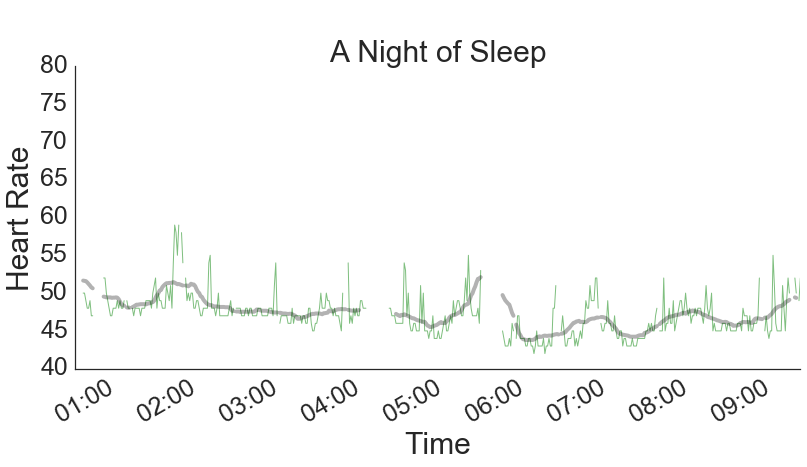

In [16]:
# plug in different dates to see variation in HR over different nights.  '2017-5-27'
plot_hr_and_hr_rolling_for_night(df_hr_continuous_min, '2017-5-27', 'green', 'black', '1', 
                                 'hr_cleaned', 'hr_rolling_cleaned', .5);

# Variation in HR from night to night.

In [17]:
def plot_hr_over_night_extra_smooth_for_overlay(df_hr_continuous_min, 
                                                date, line_color, 
                                                resample_minutes, alpha_level, 
                                                cluster):
    df_night = df_hr_continuous_min[(df_hr_continuous_min['date_sleep']==date)]
    df_night_asleep = df_night[df_night['sleep_status']==1]
    df_night_asleep['date_temporary_1'] = pd.to_datetime('2017-1-1')
    df_night_asleep['date_temporary_2'] = pd.to_datetime('2017-1-2')   
    df_night_asleep['date_time'] = df_night_asleep.index  
    df_night_asleep['date_time_temporary'] = np.nan
    df_night_asleep.loc[df_night_asleep['date_time'].dt.hour>20, 
                        'date_time_temporary'] = pd.to_datetime(
        df_night_asleep['date_temporary_1'].astype(str) + ' ' + 
        df_night_asleep['date_time'].dt.hour.astype(str) + ':' + 
        df_night_asleep['date_time'].dt.minute.astype(str))
    df_night_asleep.loc[df_night_asleep['date_time'].dt.hour<20, 
                        'date_time_temporary'] = pd.to_datetime(
        df_night_asleep['date_temporary_2'].astype(str) + ' ' + 
        df_night_asleep['date_time'].dt.hour.astype(str) + ':' + 
        df_night_asleep['date_time'].dt.minute.astype(str))
    df_night_asleep = df_night_asleep.set_index('date_time_temporary')
    df_night_asleep = df_night_asleep[df_night_asleep.index < '2017-01-02 11:00:00']
    df_night_asleep = df_night_asleep.resample(resample_minutes+'min').mean()      
    # smooth more    
    df_night_asleep['hr_rolling_cleaned'] = df_night_asleep['hr_rolling_cleaned'].interpolate()  # this isn't really necessary when have min_periods set above
    df_night_asleep['hr_rolling_cleaned'] = df_night_asleep['hr_rolling_cleaned'].rolling(
        window=20, center=True, min_periods=5).mean()
    plt.plot(df_night_asleep.index, df_night_asleep['hr_rolling_cleaned'], 
             alpha=alpha_level, color=line_color, label=cluster, linewidth=4)

def plot_hr_over_night_raw_for_overlay(df_hr_continuous_min, date, line_color, 
                                       resample_minutes, alpha_level, cluster):
    df_night = df_hr_continuous_min[(df_hr_continuous_min['date_sleep']==date)]
    df_night_asleep = df_night[df_night['sleep_status']==1]
    df_night_asleep['date_temporary_1'] = pd.to_datetime('2017-1-1')
    df_night_asleep['date_temporary_2'] = pd.to_datetime('2017-1-2')   
    df_night_asleep['date_time'] = df_night_asleep.index  
    df_night_asleep['date_time_temporary'] = np.nan
    df_night_asleep.loc[df_night_asleep['date_time'].dt.hour>20, 
                        'date_time_temporary'] = pd.to_datetime(
        df_night_asleep['date_temporary_1'].astype(str) + ' ' + 
        df_night_asleep['date_time'].dt.hour.astype(str) + ':' + 
        df_night_asleep['date_time'].dt.minute.astype(str))
    df_night_asleep.loc[df_night_asleep['date_time'].dt.hour<20, 
                        'date_time_temporary'] = pd.to_datetime(
        df_night_asleep['date_temporary_2'].astype(str) + ' ' + 
        df_night_asleep['date_time'].dt.hour.astype(str) + ':' + 
        df_night_asleep['date_time'].dt.minute.astype(str))
    df_night_asleep = df_night_asleep.set_index('date_time_temporary')
    df_night_asleep = df_night_asleep[df_night_asleep.index < 
                                      '2017-01-02 11:00:00']
    df_night_asleep = df_night_asleep.resample(resample_minutes+'min').mean()      
    df_night_asleep['hr_cleaned'] = df_night_asleep['hr_cleaned'].interpolate()  # this isn't really necessary when have min_periods set above
    plt.plot(df_night_asleep.index, df_night_asleep['hr_cleaned'], 
             alpha=alpha_level, linewidth=1, color=line_color, label=cluster)  

In [18]:
# select just records/time-points when asleep
df_hr_continuous_asleep = df_hr_continuous_min[df_hr_continuous_min['sleep_status']==1]

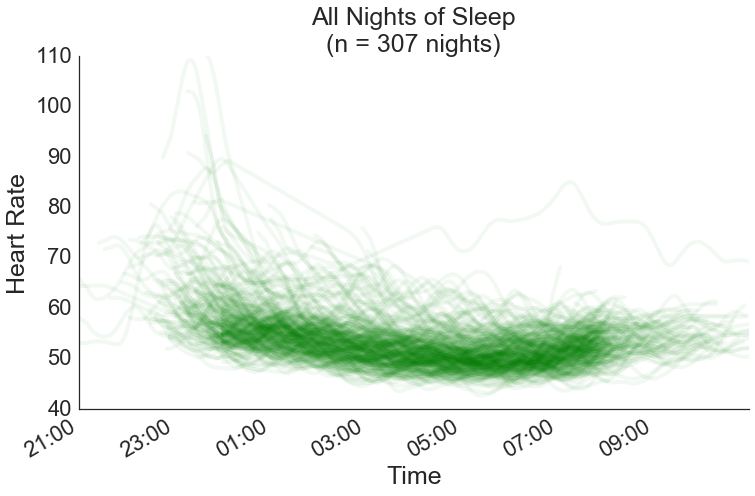

In [19]:
date_list_for_real_time = df_hr_continuous_asleep['date_sleep'].dt.date.unique()
#date_list_for_real_time = [date for date in date_list_for_real_time if date != '2016-12-18']
color = 'green'
ax = plt.figure(figsize=(12, 7))
for date in date_list_for_real_time[:]:
    #print(date)
    plot_hr_over_night_extra_smooth_for_overlay(df_hr_continuous_min, date, color, '1', .05, '')
    #plot_hr_over_night_raw_for_overlay(df_hr_continuous_min, date, color, '1', .025, '')  
ax.axes[0].xaxis.set_major_formatter(DateFormatter('%H:%M'))  
ax.autofmt_xdate()
plt.ylabel('Heart Rate', fontsize=25)
plt.xlabel('Time', fontsize=25)
plt.ylim(40,110)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)
#leg = plt.legend(fontsize=25)
#leg.get_title().set_fontsize(25)
plt.title('All Nights of Sleep\n(n = '+str(len(date_list_for_real_time))+' nights)', fontsize=25)
ax.axes[0].xaxis.set_major_formatter(DateFormatter('%H:%M'))  
ax.autofmt_xdate()
sns.despine()

# Do subjective sleep ratings relate to prior sleep's HR?

In [20]:
# examine HR from sleep onset and from waking up in the morning

# create variable that says how many minutes been sleeping that night
df_hr_continuous_asleep['consecutive_numbers'] = np.arange(
    1.,len(df_hr_continuous_asleep)+1)
df_hr_continuous_asleep['sum_minutes_asleep'] = df_hr_continuous_asleep.groupby(
    'date_sleep')['consecutive_numbers'].transform(lambda x: x.count())
df_hr_continuous_asleep['first_consecutive_number_of_group'] = df_hr_continuous_asleep.groupby(
    'date_sleep')['consecutive_numbers'].transform(lambda x: x.head(1))
df_hr_continuous_asleep['minutes_asleep'] = (df_hr_continuous_asleep['consecutive_numbers'] - 
                                             df_hr_continuous_asleep['first_consecutive_number_of_group'] + 1)

# count from sleep onset
df_hr_continuous_asleep['minutes_asleep'] = df_hr_continuous_asleep.loc[:, 'minutes_asleep'] - 1

# count backwards from waking up
df_hr_continuous_asleep['minutes_from_waking'] = (df_hr_continuous_asleep['sum_minutes_asleep'] - 
                                                  df_hr_continuous_asleep['minutes_asleep'])

In [21]:
# select just nights slept at least 5 hours and just select first 5 hours of sleep (from sleep onset)
df_hr_continuous_asleep_from_sleep_onset = df_hr_continuous_asleep[
    df_hr_continuous_asleep['sum_minutes_asleep']>300]
df_hr_continuous_asleep_from_sleep_onset = df_hr_continuous_asleep_from_sleep_onset[
    df_hr_continuous_asleep_from_sleep_onset['minutes_asleep']<300]

# select just nights slept at least 5 hours and just select last 5 hours of sleep (from waking)
df_hr_continuous_asleep_from_waking = df_hr_continuous_asleep[
    df_hr_continuous_asleep['sum_minutes_asleep']>300]
df_hr_continuous_asleep_from_waking = df_hr_continuous_asleep_from_waking[
    df_hr_continuous_asleep_from_waking['minutes_from_waking']<300]

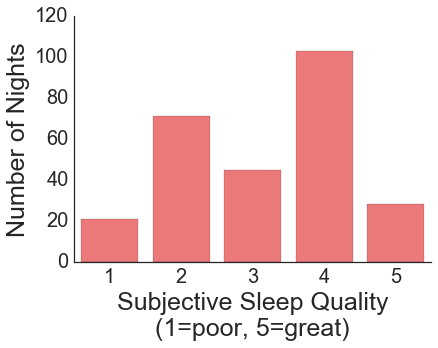

In [22]:
df_hr_day = df_hr_continuous_min.groupby('date_sleep').median()
sns.set_context('paper')
sns.countplot(df_hr_day['sleep_subjective'], color='red', alpha=.6)
plt.xlabel('Subjective Sleep Quality\n(1=poor, 5=great)', fontsize=25)
plt.ylabel('Number of Nights', fontsize=25)
plt.xticks([0,1,2,3,4], [1,2,3,4,5], fontsize=20);
plt.yticks(fontsize=20);
sns.despine()

In [23]:
# order the two dfs by subjective sleep so plots correcly
df_hr_continuous_asleep_from_onset_subjective = df_hr_continuous_asleep_from_sleep_onset.sort_values(
    by='sleep_subjective', ascending=False)
df_hr_continuous_asleep_from_waking_subjective = df_hr_continuous_asleep_from_waking.sort_values(
    by='sleep_subjective', ascending=False)

In [24]:
def bin_subjective_sleep(df):
    df['sleep_binned'] = np.nan
    df.loc[(df['sleep_subjective']==1) | (df['sleep_subjective']==2) | 
           (df['sleep_subjective']==3), 'sleep_binned'] = 'bad'
    df.loc[(df['sleep_subjective']==4) | (df['sleep_subjective']==5), 
           'sleep_binned'] = 'good'
    return df

df_hr_continuous_asleep_from_onset_subjective = bin_subjective_sleep(df_hr_continuous_asleep_from_onset_subjective)
df_hr_continuous_asleep_from_waking_subjective = bin_subjective_sleep(df_hr_continuous_asleep_from_waking_subjective)

In [25]:
df_groupby_date_sleep_from_onset = df_hr_continuous_asleep_from_onset_subjective.groupby('date_sleep').head(1)
print(len(df_groupby_date_sleep_from_onset))
good_night_onset_n = df_groupby_date_sleep_from_onset['sleep_binned'].value_counts()[0]
bad_night_onset_n = df_groupby_date_sleep_from_onset['sleep_binned'].value_counts()[1]

295


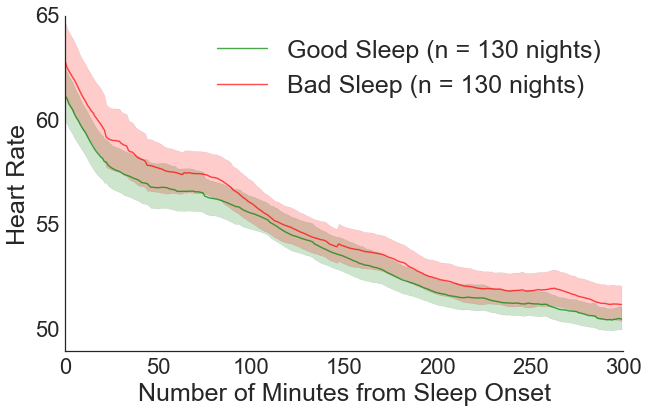

In [26]:
plt.figure(figsize=(10,6))
sns.tsplot(time='minutes_asleep', value='hr_rolling', unit='date_sleep', 
           condition='sleep_binned', ci=95, 
           data=df_hr_continuous_asleep_from_onset_subjective, 
           color=['green', 'red'], alpha=.7, n_boot=1000)
plt.legend(['Good Sleep (n = '+str(good_night_onset_n)+' nights)', 
            'Bad Sleep (n = '+str(good_night_onset_n)+' nights)'], fontsize=25)
plt.xlabel('Number of Minutes from Sleep Onset', fontsize=25)
plt.ylabel('Heart Rate', fontsize=25)
plt.xticks([0,50,100,150,200,250,300], fontsize=22)
plt.yticks([50,55,60,65], fontsize=22)
plt.ylim(49,65)
sns.despine()

In [27]:
df_groupby_date_sleep_from_waking = df_hr_continuous_asleep_from_waking_subjective.groupby('date_sleep').head(1)
good_night_waking_n = df_groupby_date_sleep_from_waking['sleep_binned'].value_counts()[0]
bad_night_waking_n = df_groupby_date_sleep_from_waking['sleep_binned'].value_counts()[1]

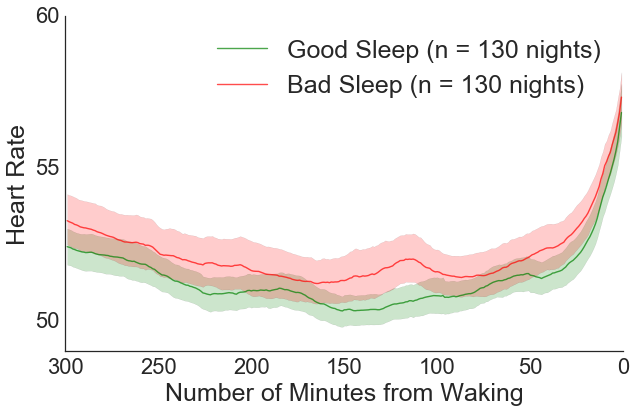

In [28]:
plt.figure(figsize=(10,6))
sns.tsplot(time='minutes_from_waking', value='hr_rolling', 
           unit='date_sleep', condition='sleep_binned', ci=95, 
           data=df_hr_continuous_asleep_from_waking_subjective, 
           color=['green', 'red'], alpha=.7, n_boot=1000)
plt.legend(['Good Sleep (n = '+str(good_night_waking_n)+' nights)', 
            'Bad Sleep (n = '+str(good_night_waking_n)+' nights)'], fontsize=25)
plt.xlabel('Number of Minutes from Waking', fontsize=25)
plt.ylabel('Heart Rate', fontsize=25)
plt.xticks([300,250,200,150,100,50,0], fontsize=22)
plt.yticks([50,55,60], fontsize=22)
plt.gca().invert_xaxis()
sns.despine()

In [29]:
def get_n_per_condition(df, variable_binned):
    n_list = []
    df_groupby_date_sleep = df.groupby('date_sleep').head(1)
    number_of_conditions = len(df_groupby_date_sleep[
            df_groupby_date_sleep[variable_binned].notnull()][variable_binned].unique())
    print('number of conditions:', number_of_conditions)
    print(len(df_groupby_date_sleep))
    for condition in range(number_of_conditions):
        condition_n = df_groupby_date_sleep[variable_binned].value_counts()[condition]
        n_list.append(condition_n)    
    return n_list

# Do energy ratings relate to prior sleep's HR?

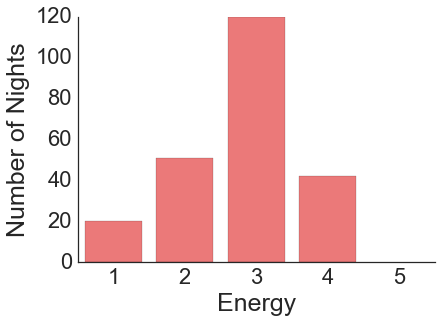

In [30]:
# remove errant negative 0 and negatives
df_hr_continuous_min.loc[df_hr_continuous_min['energy']<1, 'energy'] = np.nan

df_hr_day = df_hr_continuous_min.groupby('date_sleep').median()
sns.set_context('paper')
sns.countplot(df_hr_day['energy'], color='red', alpha=.6)
plt.xlabel('Energy', fontsize=25)
plt.ylabel('Number of Nights', fontsize=25)
plt.xticks([0,1,2,3,4], [1,2,3,4,5], fontsize=22);
plt.yticks(fontsize=22);
plt.xlim(-.5,4.5)
sns.despine()

In [31]:
# order the two dfs by energy so plots correcly
df_hr_continuous_asleep_from_onset_energy = df_hr_continuous_asleep_from_sleep_onset.sort_values(
    by='energy', ascending=False)
df_hr_continuous_asleep_from_waking_energy = df_hr_continuous_asleep_from_waking.sort_values(
    by='energy', ascending=False)

In [32]:
def bin_energy(df):    
    df.loc[df['energy']<1, 'energy'] = np.nan
    df['energy_binned'] = np.nan
    df.loc[df['energy']<3, 'energy_binned'] = 'Low Energy'
    df.loc[df['energy']>=3, 'energy_binned'] = 'High Energy'
    return df

df_hr_continuous_asleep_from_onset_energy = bin_energy(df_hr_continuous_asleep_from_onset_energy)
df_hr_continuous_asleep_from_waking_energy = bin_energy(df_hr_continuous_asleep_from_waking_energy)

In [33]:
n_list_from_onset_energy = get_n_per_condition(df_hr_continuous_asleep_from_onset_energy, 'energy_binned')
n_list_from_waking_energy = get_n_per_condition(df_hr_continuous_asleep_from_waking_energy, 'energy_binned')

number of conditions: 2
295
number of conditions: 2
295


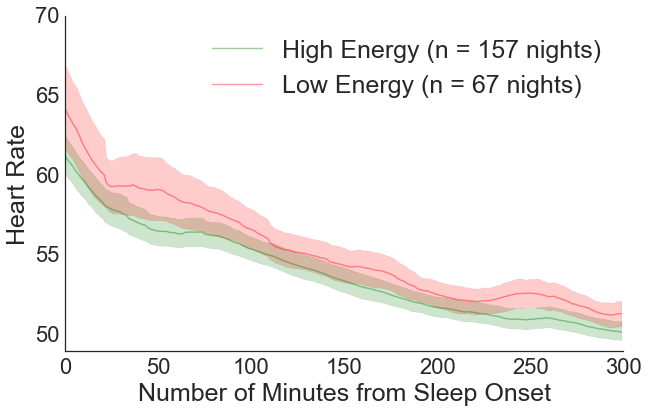

In [34]:
plt.figure(figsize=(10,6))
sns.tsplot(time='minutes_asleep', value='hr_rolling', 
           unit='date_sleep', condition='energy_binned', 
           ci=95, n_boot=1000, data=df_hr_continuous_asleep_from_onset_energy, 
           color=['green', 'red'], alpha=.4) 
plt.xlabel('Number of Minutes from Sleep Onset', fontsize=25)
plt.ylabel('Heart Rate', fontsize=25)
plt.xticks([0,50,100,150,200,250,300], fontsize=22)
plt.yticks([50,55,60,65,70], fontsize=22)
#plt.legend(title='', fontsize=25)
plt.legend(['High Energy (n = '+str(n_list_from_onset_energy[0])+' nights)',
            'Low Energy (n = '+str(n_list_from_onset_energy[1])+' nights)'], 
            fontsize=25)  
plt.ylim(49, 70)
sns.despine()

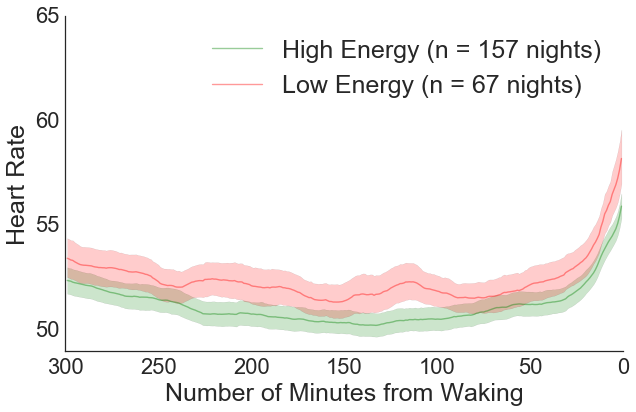

In [35]:
plt.figure(figsize=(10,6))
sns.tsplot(time='minutes_from_waking', value='hr_rolling', 
           unit='date_sleep', condition='energy_binned', 
           ci=95, n_boot=1000, 
           data=df_hr_continuous_asleep_from_waking_energy, 
           color=['green', 'red'], alpha=.4) 
plt.xlabel('Number of Minutes from Waking', fontsize=25)
plt.ylabel('Heart Rate', fontsize=25)
plt.yticks([50,55,60,65], fontsize=22)
plt.xticks([300,250,200,150,100,50,0], fontsize=22)
#plt.legend(title='', fontsize=25)
plt.legend(['High Energy (n = '+str(n_list_from_waking_energy[0])+' nights)',
            'Low Energy (n = '+str(n_list_from_waking_energy[1])+' nights)'], 
            fontsize=25)  
plt.ylim(49, 65)
plt.gca().invert_xaxis()
sns.despine()

# Correlation matrix

In [36]:
df_hr_continuous_asleep.columns

Index(['date', 'date_sleep', 'sleep_status', 'hr', 'sleep_subjective',
       'energy', 'hr_rolling', 'outlier', 'hr_cleaned', 'hr_rolling_cleaned',
       'consecutive_numbers', 'sum_minutes_asleep',
       'first_consecutive_number_of_group', 'minutes_asleep',
       'minutes_from_waking'],
      dtype='object')

In [37]:
df_by_day = df_hr_continuous_asleep.groupby('date_sleep')[['hr_cleaned', 'outlier', 
                                                           'sleep_subjective', 'energy', 
                                                           'sum_minutes_asleep']].mean()
df_by_day.tail()

,hr_cleaned,outlier,sleep_subjective,energy,sum_minutes_asleep
date_sleep,,,,,
2017-08-06,52.611966,0.006667,4.0,3.0,600.0
2017-08-07,48.536748,0.006565,3.0,2.0,457.0
2017-08-08,52.824873,0.000000,4.0,3.0,394.0
2017-08-09,49.253425,0.006579,4.0,4.0,456.0
2017-08-10,49.580097,0.000000,2.0,3.0,420.0


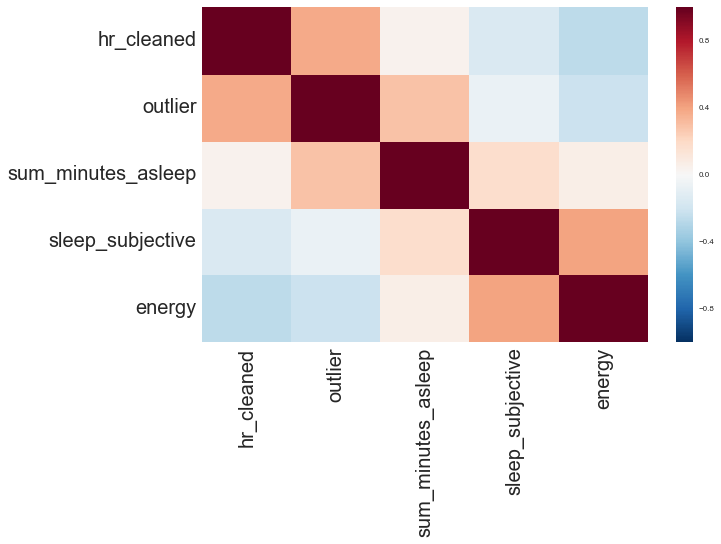

In [38]:
plt.figure(figsize=(10,6))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.heatmap(df_by_day[['hr_cleaned', 'outlier', 'sum_minutes_asleep', 
                       'sleep_subjective', 'energy']].corr())

### *Summary*...

# Do daily ratings relate to subsequent sleep's HR? No. Results below.

In [39]:
variables_for_prior_day_list = ['hr_cleaned', 'outlier', 'sleep_subjective', 
                                'energy', 'sum_minutes_asleep']

for variable in variables_for_prior_day_list:
    df_by_day[variable+'_prior'] = df_by_day[variable].shift(1)

## Next steps?
* to what extent is hr confounded with time asleep? disentangle the two.
* what predicts HR or low HR while sleeping?
* cumlative HR over multiple days and ratings. in interaction with HR from prior night vs. two nights ago.
* frequency analysis in HR time series (fft)
* HR while sleeping (and/or minutes asleep) and lowest/resting HR while awake the next day.